from sympy import Matrix, symbols, sin, cos, trigsimp, init_printing, I, \
    simplify, Eq, solve, expand, lambdify, diff, solveset, exp, factor, Sum

In [2]:
init_printing()

In [3]:
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd


In [4]:
%matplotlib inline

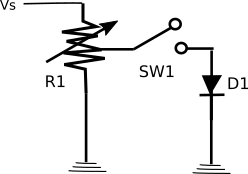

In this scenario we have a variable resistor pot R1 and a switch R1 (which is a push down switch non-toggle switch).  We measure the voltage across the variable terminal of R1 with the switch open.  This allows us to calculate the impedance of R1 with the switch open.  Then we close the swith and measure the voltage across the diode $V_D$.  Knowing the voltage across the diode and also knowing the resistance as established before we can easily calculate the voltage across the variable resister and also the current flowing through it.   Because the resistor and diode are in series this must also be the current flowing through the diode.

In [12]:
data = [(2.24, .640), (1.12, .560), (.880, .560), (.480, .480), (.400, .400), (.280, .280), 
        (.800, .640), (.960, .640), (1.2, .560), (1.44, .640), (1.60, .640), (1.84, .640),
       (2.08, .640), (2.56, .640), (3.04, .640), (3.92, .720), (4.88, .960),
       (4.72, 0.880)]

In [13]:
df1 = pd.DataFrame(list(zip(*data))).T
df1.columns=['VR', 'VD']
df1 = df1.sort_values('VR', axis='rows').reset_index(drop=True)
df1

VR    VD
0   0.28  0.28
1   0.40  0.40
2   0.48  0.48
3   0.80  0.64
4   0.88  0.56
5   0.96  0.64
6   1.12  0.56
7   1.20  0.56
8   1.44  0.64
9   1.60  0.64
10  1.84  0.64
11  2.08  0.64
12  2.24  0.64
13  2.56  0.64
14  3.04  0.64
15  3.92  0.72
16  4.72  0.88
17  4.88  0.96

R1 = (VR/5volts)\*1000 since we are using a 1K variable pot.  The current is therefore the difference between the voltage drop across the diode and 5V divided by the variable resistor impedance.

In [14]:
df1['R1'] = 1000-df1['VR']/5*1000
df1['ID'] = (5 - df1['VD'])/df1['R1']

In [15]:
df1

VR    VD     R1        ID
0   0.28  0.28  944.0  0.005000
1   0.40  0.40  920.0  0.005000
2   0.48  0.48  904.0  0.005000
3   0.80  0.64  840.0  0.005190
4   0.88  0.56  824.0  0.005388
5   0.96  0.64  808.0  0.005396
6   1.12  0.56  776.0  0.005722
7   1.20  0.56  760.0  0.005842
8   1.44  0.64  712.0  0.006124
9   1.60  0.64  680.0  0.006412
10  1.84  0.64  632.0  0.006899
11  2.08  0.64  584.0  0.007466
12  2.24  0.64  552.0  0.007899
13  2.56  0.64  488.0  0.008934
14  3.04  0.64  392.0  0.011122
15  3.92  0.72  216.0  0.019815
16  4.72  0.88   56.0  0.073571
17  4.88  0.96   24.0  0.168333

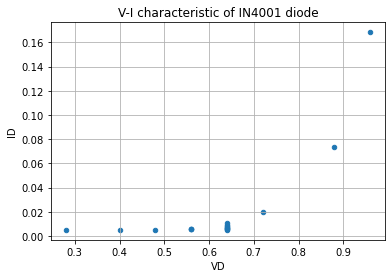

In [43]:
fig, ax = plt.subplots()

x = np.linspace(0.2, 0.74, 1000)
ax.set_title('V-I characteristic of BC547 as diode')
ax.set_ylabel('current $I_D$ (mA)')
ax.set_xlabel('voltage $V_D$')

ax1 = df1.plot('VD', 'ID', kind='scatter', ax=ax)
ax1.grid()

Lets try a simple linear regression to see where that gets us

In [17]:
z = np.polyfit(df1['VD'], df1['ID'], 1)
# Create the polynomial from the coefficients
p = np.poly1d(z)
# View the coefficients themselves
p.c

array([ 0.19206313, -0.09912839])

[ 0.19206313 -0.09912839]
[0.00808523 0.00185739]


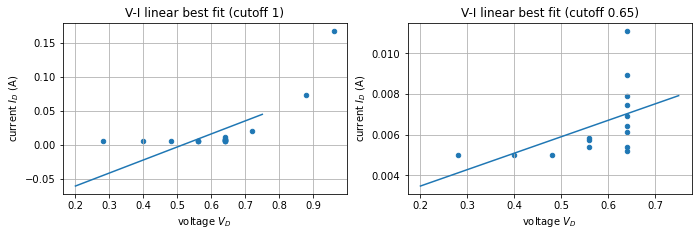

In [18]:
fig, axs = plt.subplots(1,2, squeeze=True, figsize=(10,3.5))
fig.tight_layout(pad=3.0)
x = np.linspace(0.2, 0.75, 1000)
cutoffs = [1, .65]
for ax, c in zip(axs, cutoffs):
    df = df1[df1['VD']<c]
    ax.set_title('V-I linear best fit (cutoff {})'.format(c))
    z = np.polyfit(df['VD'], df['ID'], 1)
    # Create the polynomial from the coefficients
    p = np.poly1d(z)
    print (p.c)
    ax.plot(x, p(x))
    dfax = df.plot('VD', 'ID', kind='scatter', ax=ax)
    dfax.set_ylabel('current $I_D$ (A)')
    dfax.set_xlabel('voltage $V_D$')
    dfax.grid()

So in spite of looking like I might be able to fit part of the equation linearly it really performs poorly when zooming in further.

In [19]:
Id, id1, id2, k, vd, vd1, vd2,  Is, r1, vs = symbols("i_D i_{D1} i_{D2} k V_D V_{D1} V_{D2} I_S R_1 V_s")

This is based on the Shockley diode model at https://en.wikipedia.org/wiki/Diode_modelling#Shockley_diode_model given below


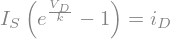

In [20]:
expr1 = Eq(Is * (exp(vd/k)-1), Id); expr1

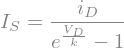

In [21]:
expr2 = Eq(Is, solve(expr1, Is)[0]); expr2

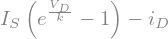

In [22]:
e1 = expr1.args[0] - expr1.args[1]; e1

Now construct a non linear reqression function, which we will later try to minimise, as a sum of the squares of the residuals based on our data points.

In [23]:
def sumsq(params, args):
    #print (params)
    #print (type(args))
    sqtot = 0
    isv, kval = params
    df = args
    f = lambdify((Id, vd), e1.subs([(Is, isv),(k,kval)]))
    for ii in range(0, len(df)):
        vdv = df.iloc[ii]['VD']
        idv = df.iloc[ii]['ID']
        sqtot += (f(idv, vdv)**2)
    return sqtot
        

We do this crude minimisation which follows just to get an initial guess for scipy.  We basically just create a grid, of K's and $I_S$ values, for the domain and then look for the lowest value so pretty crude really but it only takes about 3 seconds to execute.

In [24]:
def crude_minimise():
    minres = [999, 999, 999]
    for isval in np.logspace(-16, -6, 10):
        for kval in np.linspace(0.01, 0.03, 20):
            sqsum = sumsq((isval, kval),df1)
            if sqsum < minres[0]:
                minres = (sqsum, isval, kval)
    return (minres)

In [25]:
crude_result = crude_minimise()
crude_result

In [26]:
initial_guess = crude_result[1:]
result = optimize.minimize(sumsq, initial_guess, args=(df1,), method='Powell')
result


   direc: array([[1., 0.],
       [0., 1.]])
     fun: 0.004938514960094522
 message: 'Optimization terminated successfully.'
    nfev: 71
     nit: 2
  status: 0
 success: True
       x: array([1.29154967e-15, 2.95172030e-02])

Strangely the scipy optimisation method works no better than my crude method so maybe I am doing something wrong here.

In [27]:
# Just do a quick sanity check
sumsq(result.x, df1)

In [28]:
f3 = lambdify(vd, expr1.subs([(Is, result.x[0]), (k, result.x[1])]).args[0],"numpy")


Now plot the data and the fit to see how good it looks

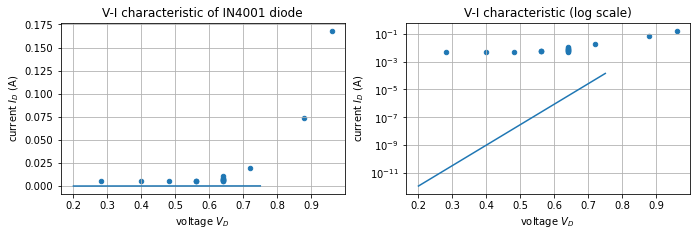

In [29]:
fig, axs = plt.subplots(1,2, squeeze=False, figsize=(10,3.5))
fig.tight_layout(pad=3.0)
x = np.linspace(0.2, 0.75, 1000)
y = [f3(x1) for x1 in x]
axs[0][1].set_yscale('log')
axs[0][0].set_title('V-I characteristic of IN4001 diode')
axs[0][1].set_title('V-I characteristic (log scale)')
for ax in axs[0]:
    
    ax.plot(x, y)
    dfax = df1.plot('VD', 'ID', kind='scatter', ax=ax)
    # For some reason labels have to be set on the pandas plot axes object
    dfax.set_ylabel('current $I_D$ (A)')
    dfax.set_xlabel('voltage $V_D$')
    dfax.grid()
    

OK, Let's try piecewise exponentials to see how that performs

In [30]:
initial_guess = crude_result[1:]
result = optimize.minimize(sumsq, initial_guess, args=(df1[df1['VD']>0.65],), method='Powell')
f3 = lambdify(vd, expr1.subs([(Is, result.x[0]), (k, result.x[1])]).args[0],"numpy")
result


   direc: array([[1., 0.],
       [0., 1.]])
     fun: 0.004264144498636393
 message: 'Optimization terminated successfully.'
    nfev: 71
     nit: 2
  status: 0
 success: True
       x: array([1.29154967e-15, 2.95172076e-02])

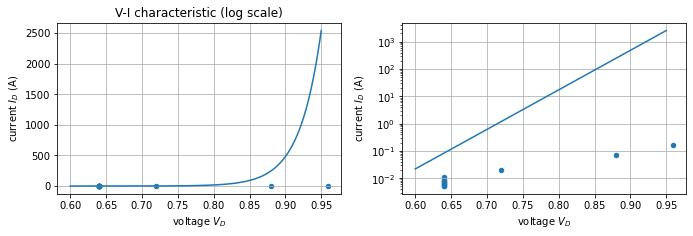

In [41]:
fig, axs = plt.subplots(1,2, squeeze=True, figsize=(10,3.5))
df = df1[df1['VD']>0.6]
fig.tight_layout(pad=3.0)
x = np.linspace(.6, 0.95, 1000)
y = [f3(x1) for x1 in x]
axs[1].set_yscale('log')
axs[0].set_title('V-I characteristic of IN4001 diode')
axs[0].set_title('V-I characteristic (log scale)')
for ax in axs:
    
    ax.plot(x, y)
    dfax = df.plot('VD', 'ID', kind='scatter', ax=ax)
    # For some reason labels have to be set on the pandas plot axes object
    dfax.set_ylabel('current $I_D$ (A)')
    dfax.set_xlabel('voltage $V_D$')
    dfax.grid()
    

In [32]:
initial_guess = crude_result[1:]
result = optimize.minimize(sumsq, initial_guess, args=(df1[df1['VD']<0.6],), method='Powell')
f3 = lambdify(vd, expr1.subs([(Is, result.x[0]), (k, result.x[1])]).args[0],"numpy")
result


   direc: array([[0.00000000e+00, 1.00000000e+00],
       [1.39272661e-13, 1.52004189e-08]])
     fun: 7.101803368426422e-05
 message: 'Optimization terminated successfully.'
    nfev: 79
     nit: 2
  status: 0
 success: True
       x: array([4.53602474e-11, 3.00098838e-02])

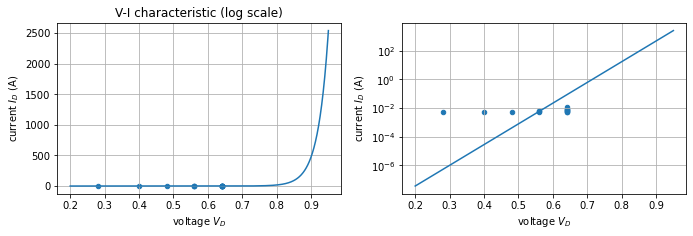

In [40]:
fig, axs = plt.subplots(1,2, squeeze=True, figsize=(10,3.5))
fig.tight_layout(pad=3.0)
x = np.linspace(0.2, 0.95, 1000)
y = [f3(x1) for x1 in x]
axs[1].set_yscale('log')
axs[0].set_title('V-I characteristic of BC547 as diode')
axs[0].set_title('V-I characteristic (log scale)')
for ax in axs:
    
    ax.plot(x, y)
    dfax = df1[df1['VD']<0.65].plot('VD', 'ID', kind='scatter', ax=ax)
    # For some reason labels have to be set on the pandas plot axes object
    dfax.set_ylabel('current $I_D$ (A)')
    dfax.set_xlabel('voltage $V_D$')
    dfax.grid()
    

At this point I wonder if this is really the best approximation or whether there is some corruption to my measurement data that is failing to fit the model or whether my experimental setup is insufficient for determing the diode's reverse saturation current.

Now I try a polynomial fit.  The smallest degree polynomial that doesn't suffer from visible polynomial wiggle is degree 7.

Now plot the polyfit to see how it looks against the data

In [34]:
import numpy as np
from numpy.polynomial import polynomial
# Find the coefficients of the polynomial
z = polynomial.polyfit(df1['VD'], df1['ID'], 7)
# Create the polynomial from the coefficients
p = np.poly1d(np.flip(z))
z

array([   -7.0862616 ,    96.6629177 ,  -548.33950311,  1680.87460637,
       -3010.85639794,  3154.74267379, -1792.26540097,   426.58575282])

Text(0.5, 0, 'voltage $V_D$')

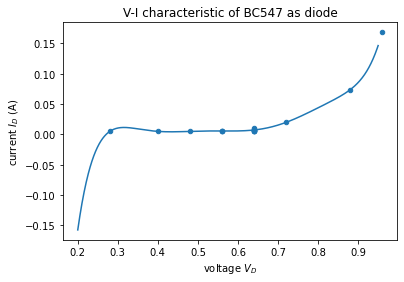

In [39]:
fig, ax = plt.subplots()
x = np.linspace(.2,.95, 1000)
y = [f3(x1) for x1 in x]
ax.set_title('V-I characteristic of BC547 as diode')
ax.plot(x, p(x))
dfax = df1.plot('VD', 'ID', kind='scatter', ax=ax)
dfax.set_ylabel('current $I_D$ (A)')
dfax.set_xlabel('voltage $V_D$')


.... and if we take a lower domain size and assume a cutoff point

In [29]:
import numpy as np
from numpy.polynomial import polynomial


# Find the coefficients of the polynomial.
z = polynomial.polyfit(df['VD'], df['ID'], 3)
# Create the polynomial from the coefficients
p = np.poly1d(np.flip(z))
# Here are the coefficients in ASCENDING order of degree.  (ie c0 +c1 *x + c2*x^2 + ...)
# numpy.polyfit returns them in opposite order
z

array([ -7.68332739,  36.27082903, -57.09422914,  29.99082255])

Text(0.5, 0, 'voltage $V_D$')

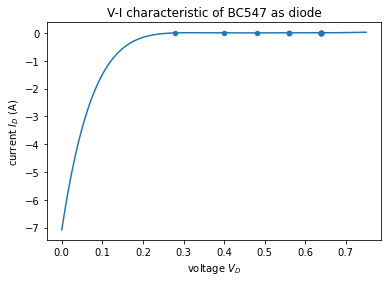

In [38]:
fig, ax = plt.subplots()
x = np.linspace(0,.75, 1000)
df = df1[df1['VD']<0.65]
y = [f3(x1) for x1 in x]
ax.set_title('V-I characteristic of BC547 as diode')
ax.plot(x, p(x))
dfax = df.plot('VD', 'ID', kind='scatter', ax=ax)
dfax.set_ylabel('current $I_D$ (A)')
dfax.set_xlabel('voltage $V_D$')


How does the polynomial fit compare against the exponential fit, especially at the high range.

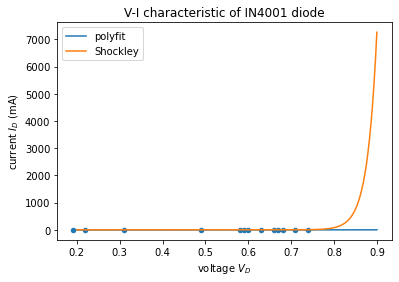

In [31]:
fig, ax = plt.subplots()
x = np.linspace(.2,.9, 1000)
y = [f3(x1) for x1 in x]
ax.set_title('V-I characteristic of IN4001 diode')
ax.plot(x, p(x), label='polyfit')
ax.plot(x, y, label='Shockley')
dfax = df1.plot('VD', 'ID', kind='scatter', ax=ax)
dfax.set_ylabel('current $I_D$ (mA)')
dfax.set_xlabel('voltage $V_D$')
dfax.legend()


This shows how a polyfit will always undershoot an exponential so from 0.65 volts onwards it seems I am not going to be able to find a polyfit that will follow it for very long without going to a large number of terms.  The following image I found on Quora but it would seem to indicate that no exponential model is going to match what happens in the reverse bias and forward bias region of the diode anyway.

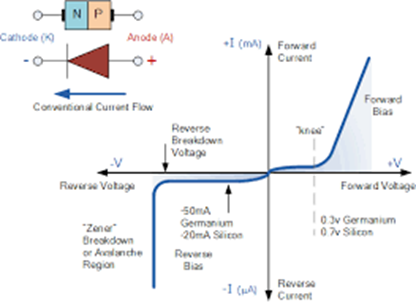

Out of curiousity I plot the inline resistance with the diode against the voltage acrosss the diode.

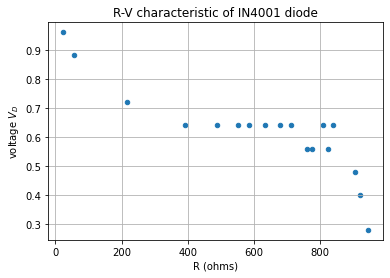

In [37]:
fig, ax = plt.subplots()
ax.set_title('R-V characteristic of IN4001 diode')
dfax = df1.plot('R1', 'VD', kind='scatter', ax=ax)
dfax.set_xlabel('R (ohms)')
dfax.set_ylabel('voltage $V_D$')
dfax.grid()
